In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import load_model
from common_variables import *

In [2]:
np.random.seed(seed)
tf.random.set_seed(seed)

In [3]:
df = pd.read_csv(test_time_series_path, dayfirst = True, index_col=['Date'], parse_dates=['Date'], usecols=['Date','HLAvg','MA','Returns'])

In [4]:
scaler = joblib.load(scaler_path)
df['Scaled'] = scaler.transform(df[['Returns']].values)

In [5]:
model = load_model(model_path)

In [6]:
scaled = df['Scaled'].values
X = []
len_scaled = len(scaled)
for i in range(window_size, len_scaled):
    X.append(scaled[i-window_size:i])
X = np.asarray(X)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))
y_true = scaled[-X.shape[0]:]
print(f"X {X.shape}, y_real {y_true.shape}")

X (262144, 256, 1), y_real (262144,)


In [7]:
mse = model.evaluate(X, y_true, verbose=1)
print("Mean Squared Error:", mse)

8192/8192 [==============================] - 60s 7ms/step - loss: 4.6984e-06
Mean Squared Error: 4.698353222920559e-06


In [8]:
y_pred = model.predict(X)
y_pred.shape

(262144, 1)

In [9]:
df['Pred_Scaled'] = np.pad(y_pred.reshape(y_pred.shape[0]), (window_size, 0), mode='constant', constant_values=np.nan)
df['Pred_Returns'] = scaler.inverse_transform(df[['Pred_Scaled']].values)
#df['Pred_MA'] = df["MA"].mul(1 + df['Pred_Returns'].shift(-1)).shift(1) # Arithmetic Returns
df['Pred_MA'] = df['MA'].mul(np.exp(df['Pred_Returns'].shift(-1))).shift(1) # Log Returns
df = df[window_size:]
df

,HLAvg,MA,Returns,Scaled,Pred_Scaled,Pred_Returns,Pred_MA
Date,,,,,,,
2019-12-23 21:49:00,1.293740,1.293930,-0.000015,0.606670,0.607260,-0.000012,1.293935
2019-12-23 21:50:00,1.293700,1.293911,-0.000015,0.606720,0.607408,-0.000011,1.293916
2019-12-23 21:51:00,1.293555,1.293882,-0.000022,0.605455,0.607214,-0.000012,1.293895
2019-12-23 21:52:00,1.293585,1.293855,-0.000021,0.605657,0.604892,-0.000025,1.293850
2019-12-23 21:53:00,1.293625,1.293829,-0.000020,0.605809,0.605654,-0.000021,1.293828
...,...,...,...,...,...,...,...
2020-09-04 20:55:00,1.327765,1.327645,0.000006,0.610540,0.608648,-0.000005,1.327631
2020-09-04 20:56:00,1.328065,1.327686,0.000031,0.615276,0.611623,0.000012,1.327660
2020-09-04 20:57:00,1.328145,1.327736,0.000038,0.616411,0.615711,0.000034,1.327731


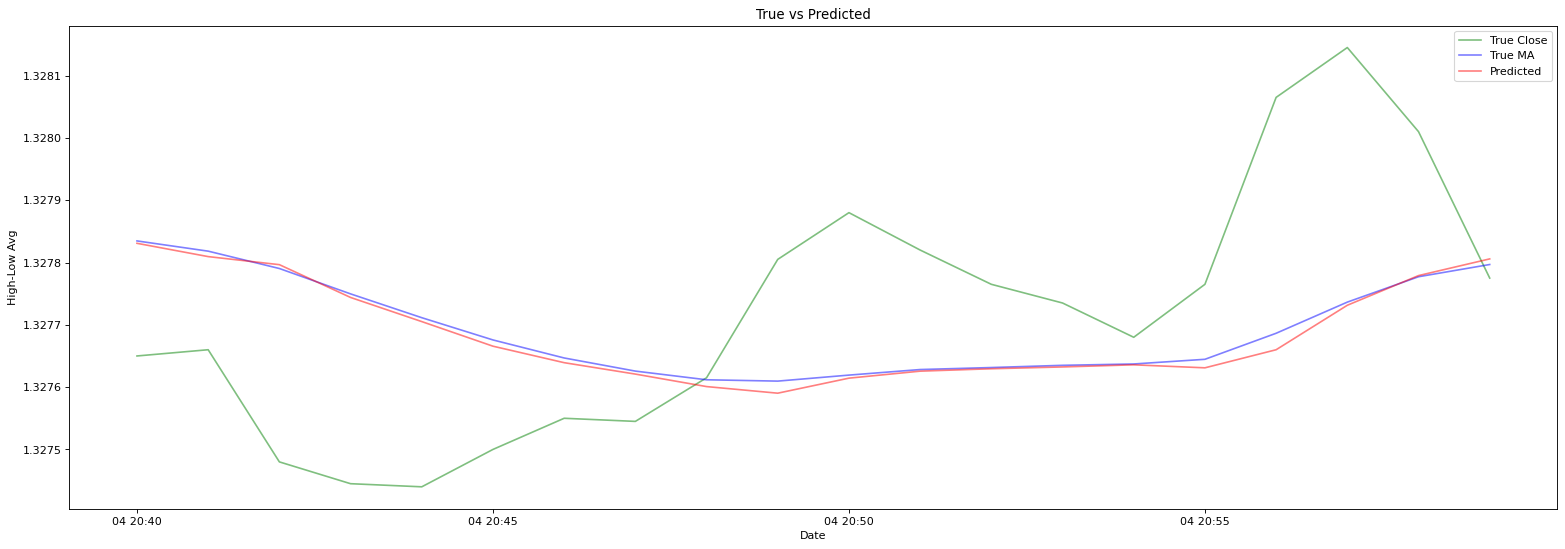

In [10]:
plt.figure(figsize=(24, 8), dpi=80, facecolor='w', edgecolor='k')
plt.plot(df['HLAvg'][-20:], color = 'green', label = 'True HLAvg', alpha=0.5)
plt.plot(df['MA'][-20:], color = 'blue', label = 'True MA', alpha=0.5)
plt.plot(df['Pred_MA'][-20:], color = 'red', label = 'Predicted', alpha=0.5)
plt.title('True vs Predicted')
plt.xlabel('Date')
plt.ylabel('High-Low Avg')
plt.legend()
plt.show()